In [8]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from src.config import PROCESSED_DATA_DIR

processed_train_path: Path = PROCESSED_DATA_DIR / "trainset.csv"
processed_test_path: Path = PROCESSED_DATA_DIR / "testset.csv"

df_train = pd.read_csv(str(processed_train_path), index_col='id')
df_test = pd.read_csv(str(processed_test_path), index_col= 'id')

X_train, y_train = df_train.drop(columns=['r_spread']), df_train.loc[:,'r_spread']
X_test, y_test = df_test.drop(columns=['r_spread']), df_test.loc[:,'r_spread']


In [24]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)


RandomForestRegressor()

In [25]:
processed_test_path: Path = PROCESSED_DATA_DIR / "testset.csv"
df_test = pd.read_csv(str(processed_test_path), index_col= 'id')

X_test, y_test = df_test.drop(columns=['r_spread']), df_test.loc[:,'r_spread']

In [26]:
rfr.score(X_test, y_test)

0.010533868226157983

In [27]:
#202201160kan
X_test.loc['202201160kan']

temperature       30.0000
humidity_pct      78.0000
wind_speed         8.0000
week              19.0000
tm_first_downs    24.3125
                   ...   
week_day_Sat       0.0000
week_day_Sun       1.0000
week_day_Thu       0.0000
week_day_Tue       0.0000
week_day_Wed       0.0000
Name: 202201160kan, Length: 167, dtype: float64

In [28]:
rfr.predict(X_test.loc[['202201160kan', '202211270was', '202309170tam']])

array([10.78,  3.26,  9.17])

In [29]:
y_test.loc[['202201160kan', '202211270was', '202309170tam']]

id
202201160kan    21
202211270was     6
202309170tam    10
Name: r_spread, dtype: int64

In [30]:
import joblib
from src.config import MODELS_DIR

rfrv1_output_path = MODELS_DIR / "rfr_v1.0.0.pkl"
joblib.dump(rfr, rfrv1_output_path) 

['G:\\Work\\DS\\dont-bet-on-sports\\models\\rfr_v1.0.0.pkl']

### Neural Network with PyTorch

In [12]:
from src.config import PROCESSED_DATA_DIR
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

processed_train_path: Path = PROCESSED_DATA_DIR / "trainset.csv"
processed_test_path: Path = PROCESSED_DATA_DIR / "testset.csv"

df_train = pd.read_csv(str(processed_train_path), index_col='id')
df_test = pd.read_csv(str(processed_test_path), index_col= 'id')

X_train, y_train = df_train.drop(columns=['r_spread']).values, df_train.loc[:,'r_spread'].values
X_test, y_test = df_test.drop(columns=['r_spread']).values, df_test.loc[:,'r_spread'].values

X_train = torch.tensor(X_train, dtype=torch.float32).to(device=device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device=device)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32).to(device=device)



Using device: cuda


In [13]:

class NFLPredictor(nn.Module):
    def __init__(self, input_dim):
        super(NFLPredictor, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

        # Dropout and Layer Normalization
        self.dropout = nn.Dropout(0.3)
        self.norm1 = nn.LayerNorm(512)
        self.norm2 = nn.LayerNorm(256)
        self.norm3 = nn.LayerNorm(128)

        # Activation function
        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):
        # Layer 1
        x1 = self.activation(self.norm1(self.layer1(x)))
        x1 = self.dropout(x1)

        # Layer 2 
        x2 = self.activation(self.norm2(self.layer2(x1)))
        x2 = self.dropout(x2)

        # Layer 3
        x3 = self.activation(self.norm3(self.layer3(x2)))
        x3 = self.dropout(x3)

        # Layer 4
        x4 = self.activation(self.layer4(x3))

        # Output layer
        output = self.output(x4)
        return output

# Initialize the model
input_dim = X_train.shape[1]
model = NFLPredictor(input_dim).to(device=device)

# Define loss function and optimizer
criterion = nn.L1Loss()  # Using MAE
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training loop with batch training
train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(X_train, y_train), batch_size=16, shuffle=True
)

epochs = 100
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Adjust learning rate with scheduler
    scheduler.step(loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = criterion(test_predictions, y_test)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Loss: 1.0384
Epoch [20/100], Loss: 0.8219
Epoch [30/100], Loss: 0.5430
Epoch [40/100], Loss: 0.3958
Epoch [50/100], Loss: 0.5150
Epoch [60/100], Loss: 0.7396
Epoch [70/100], Loss: 0.0774
Epoch [80/100], Loss: 0.6316
Epoch [90/100], Loss: 0.4720
Epoch [100/100], Loss: 0.3729
Test Loss (MAE): 0.8134


In [44]:
# Example prediction on new unseen data
results = None
with torch.no_grad():
    results = model(X_test).cpu()
    # Print raw predictions and true values for comparison
results = scaler_y.inverse_transform(results)
print("Predictions:", results[:5].flatten())
print("True Values:", scaler_y.inverse_transform(y_test[:5].cpu()))


Predictions: [ 2.35267045  2.18114029 -0.68994973  0.6788896   2.35676714]
True Values: [[ -5.99999993]
 [ 17.99999926]
 [  2.99999998]
 [-10.99999987]
 [-13.99999966]]


In [14]:
from src.config import MODELS_DIR

nn_path = MODELS_DIR / "neural_net.pt"
torch.save(model.state_dict(), str(nn_path))

In [6]:
import matplotlib.pyplot as plt
from src.config import PROCESSED_DATA_DIR, INTERIM_DATA_DIR
from src.modeling.nn import neuralnets
from src.config import MODELS_DIR

nn_path = MODELS_DIR / "neural_net.pt"
input_dim = X_train.shape[1]
model = neuralnets.NFLPredictor(input_dim).to(device=device)
model.load_state_dict(torch.load(str(nn_path), weights_only=True))
model.eval()
results = None
with torch.no_grad():
    results = model(X_test).cpu()
results = scaler_y.inverse_transform(results)

int_test_path : Path = INTERIM_DATA_DIR / "testset.csv"
df_int = pd.read_csv(str(int_test_path), index_col='id')
df_pred = pd.DataFrame({'r_spread': df_test['r_spread'].values.tolist(), 'pred': results.flatten().tolist(), 'spread_line': df_int['tm_spread'].values.tolist()})

Total Wagered: 0
Total PnL: 0


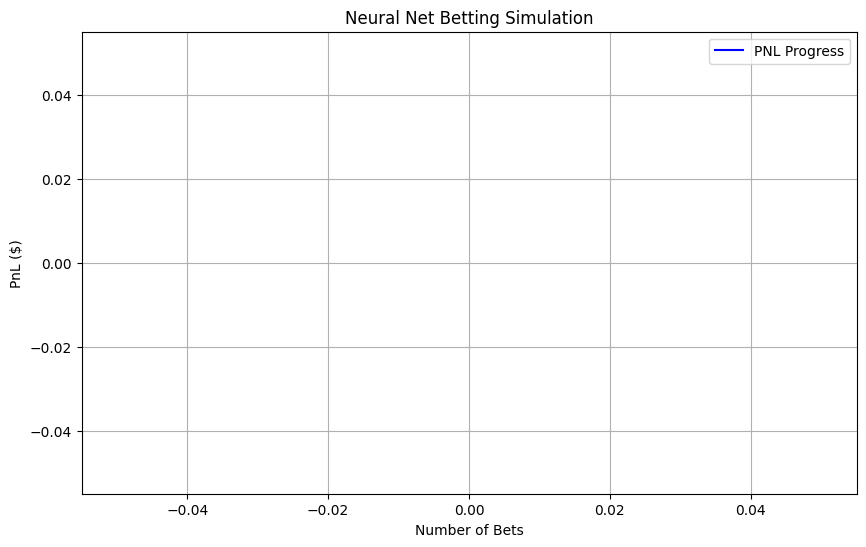

In [7]:
# Initialize variables for pnl and profit/loss
current_pnl = 0
wager_amount = 110  # Wager $110 per bet to win $100
total_wagered = 0

# Initialize a list to store pnl after each bet
pnl_progress = []

# Loop through each row to simulate the bets
for index, row in df_pred.iterrows():
    actual_r_spread = row['r_spread']
    prediction = row['pred']
    spread_line = row['spread_line']
    
    # Betting strategy: Bet on the team if pred > spread_line (predicting the team will cover the spread)
    if spread_line < 0 and (prediction - abs(spread_line)) > 3:
        # If actual r_spread (team's win margin) covers the spread line, bet wins
        total_wagered+=wager_amount
        if actual_r_spread > abs(spread_line):
            current_pnl += 100  # Win $100
        else:
            current_pnl -= wager_amount  # Lose $110 due to vigorish (110)
    elif spread_line > 0 and (abs(prediction) - spread_line) > 3:
        # If actual r_spread (team's win margin) covers the spread line, bet wins
        total_wagered+=wager_amount
        if abs(actual_r_spread) > spread_line:
            current_pnl += 100  # Win $100
        else:
            current_pnl -= wager_amount  # Lose $110 due to vigorish (110)

    # Append the current pnl to the list for tracking progress
    pnl_progress.append(current_pnl)

# Add the pnl progress to the DataFrame for visualization
df_pred['pnl'] = pnl_progress
squeezed_pnl = df_pred['pnl'].loc[df_pred['pnl'].shift() != df_pred['pnl']].reset_index(drop=True)

print(f"Total Wagered: {total_wagered}")
print(f"Total PnL: {current_pnl}")
# Plot the pnl progression over time (as bets progress)
plt.figure(figsize=(10, 6))
plt.plot(squeezed_pnl, label='PNL Progress', color='b')
plt.title('Neural Net Betting Simulation')
plt.xlabel('Number of Bets')
plt.ylabel('PnL ($)')
plt.legend()
plt.grid(True)
plt.show()


